### Обучение матриц проекции - 2

Реализуем процесс обучения матриц проекции, который был предложен на SemEval CRIM. Для этого сначала требуется загрузить какие-нибудь эмбеддинги для слов и подобрать то, каких именно кандидатов требуется ранжировать при выдаче гиперонимов.

Начнём с простой стратегии. Возьмём обученную модель FastText и загрузим эмбеддинги из неё. После этого будем для многословных термов усреднять эмбеддинги.

Теперь сделаем так, чтобы эмбеддинги можно было при желании дообучать. Для этого был написан специальный класс `Vocab`, который и будем использовать.

В случае с многословными термами (мультитокенами) он отдаёт список индексов слов в словаре. Соответственно, будет необходимо усреднить эмбеддинги по одной из осей.

In [30]:
import sys
import json
from os.path import join
import os
sys.path.append("../")
import fasttext as ft
from thesaurus_parsing.thesaurus_parser import ThesaurusParser
from vocab import Vocab
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
import torch
print(torch.__version__)

1.2.0


**Определение модели**

Определим модель, в которой будет 1 матрица проекции и логистическая регрессия на косинусных расстояниях до проекций.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cpu'

**Цикл обучения модели**

Для того, чтобы обучить модель, надо сделать следующие шаги:

* Добавить пары корректных гипонимов-гиперонимов
* Для каждого положительного добавить несколько отрицательных (пока просто случайные слова)
* Добавить вектор правильных ответов

Сделаем из этого `torch.Dataset`

In [18]:
thesaurus = ThesaurusParser('../data/RuThes/', need_closure=False)

In [31]:
vocab = Vocab(empty=True)

In [32]:
with open('vocab_lenta_100k.json') as vocab_file:
    vocab.construct_from_file(vocab_file)

In [43]:
class HypernymQueriesDataset(Dataset):
    def load_train_items(self, thesaurus, vocab, train_keys):
        self.train_items = []
        for hyponym in tqdm(train_keys):
            hypernyms = thesaurus.hypernyms_dict[hyponym]
            for hypernym in hypernyms:
                self.train_items.append([hyponym, hypernym, True])
            
            negative_examples = np.random.choice(
                list(vocab.word_to_id.keys()),
                size=self.n_negative * len(hypernyms)
            )
            
            for negative in negative_examples:
                self.train_items.append([hyponym, negative, False])
                
            if self.max_pairs is not None and len(self.train_items) > self.max_pairs:
                break
    
    def __init__(self, thesaurus, vocab, train_keys, n_negative=3, max_pairs=None):
        self.n_negative = n_negative
        self.thesaurus = thesaurus
        self.vocab = vocab
        self.max_pairs = max_pairs
        
        self.load_train_items(thesaurus, vocab, train_keys)
        
    def __len__(self):
        return len(self.train_items)
    
    def __getitem__(self, idx):
        hyponym, hypernym, label = self.train_items[idx]
        return (hyponym, hypernym, label)

In [44]:
with open('train_keys') as train_file:
    train_keys = train_file.readlines()
train_keys = [key[:-1] if key[-1] == '\n' else key for key in train_keys]

In [181]:
dataset = HypernymQueriesDataset(thesaurus, vocab, train_keys, max_pairs=100000)

Создадим ещё тестовый датасет, чтобы проверять качество на нём во время обучения. Пока будем смотреть только на функцию ошибки.

In [182]:
with open('test_keys') as test_file:
    test_keys = test_file.readlines()
test_keys = [key[:-1] if key[-1] == '\n' else key for key in test_keys]

In [183]:
test_dataset = HypernymQueriesDataset(thesaurus, vocab, test_keys, max_pairs=10000)

In [230]:
class CRIMModelVocab(nn.Module):
    def __init__(self, vocab, n_matrices=5, embedding_dim=300, init_sigma=0.01):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_matrices = n_matrices
        self.init_sigma = init_sigma
        
        matrix_shape = (n_matrices, 1, embedding_dim, embedding_dim)
        self.matrices = torch.FloatTensor(size=matrix_shape)
        self.prob_layer = nn.Linear(in_features=n_matrices, out_features=1)
        
        for i in range(n_matrices):
            eye_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim))
            noise_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim))
            torch.nn.init.eye_(eye_tensor)
            torch.nn.init.normal_(noise_tensor, std=init_sigma)
            self.matrices[i][0] = eye_tensor + noise_tensor
            
        torch.nn.init.normal_(self.prob_layer.weight, std=0.1)
        self.matrices = nn.Parameter(self.matrices.requires_grad_())
        
        emb_matrix, pad_idx = vocab.get_embedding_table()
        emb_tensor = torch.FloatTensor(emb_matrix)
        self.embedding_layer = nn.Embedding.from_pretrained(emb_tensor, freeze=False, padding_idx=pad_idx)
        self.vocab = vocab
        self.pad_idx = pad_idx
    
    def batch_to_embeddings(self, indices_batch):
        embeddings = self.embedding_layer(indices_batch)
        not_pad = indices_batch != self.pad_idx
        emb_sum = torch.sum(embeddings, dim=1)
        not_pad_sum = torch.sum(not_pad, dim=1).unsqueeze(1)
        not_pad_sum[not_pad_sum == 0] = 1
        return emb_sum / not_pad_sum.float()
    
    def forward(self, input_dict):
        candidate = input_dict['candidate']
        candidate = self.batch_to_embeddings(candidate)
        candidate_batch = candidate.shape[0]
        candidate = candidate.view((candidate_batch, 1, self.embedding_dim))
        
        batch = input_dict['batch']
        batch = self.batch_to_embeddings(batch).unsqueeze(-1)
        batch_size = batch.shape[0]
        
        projections = torch.matmul(self.matrices, batch).permute(1, 0, 2, 3).squeeze(-1)
        similarities = F.cosine_similarity(projections, candidate, dim=-1)
        logits = self.prob_layer(similarities)
        return logits

In [231]:
model = CRIMModelVocab(n_matrices=1, vocab=vocab)
optimizer = Adam(model.parameters(), lr=3e-3)
n_epochs = 3
batch_size = 64
plot_frequency = 50
val_freq = 1000
loss_fn = nn.BCEWithLogitsLoss()

In [232]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [233]:
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True)
for b in test_loader:
    test_batch = b
    break

In [234]:
def eval_loss_on_test(model, vocab):
    model.eval()
    hyponyms, candidates, labels = test_batch
    hyponyms = vocab.process_batch(hyponyms)
    candidates = vocab.process_batch(candidates)
    model_batch = {
        'batch': torch.LongTensor(hyponyms),
        'candidate': torch.LongTensor(candidates)
    }
    labels = labels.float()
    logits = model(model_batch).squeeze()
    loss = loss_fn(logits, labels)
    return loss.detach().numpy()

In [235]:
loss_history = []
test_loss_history = []
matrix_norms = []
weight_norms = []

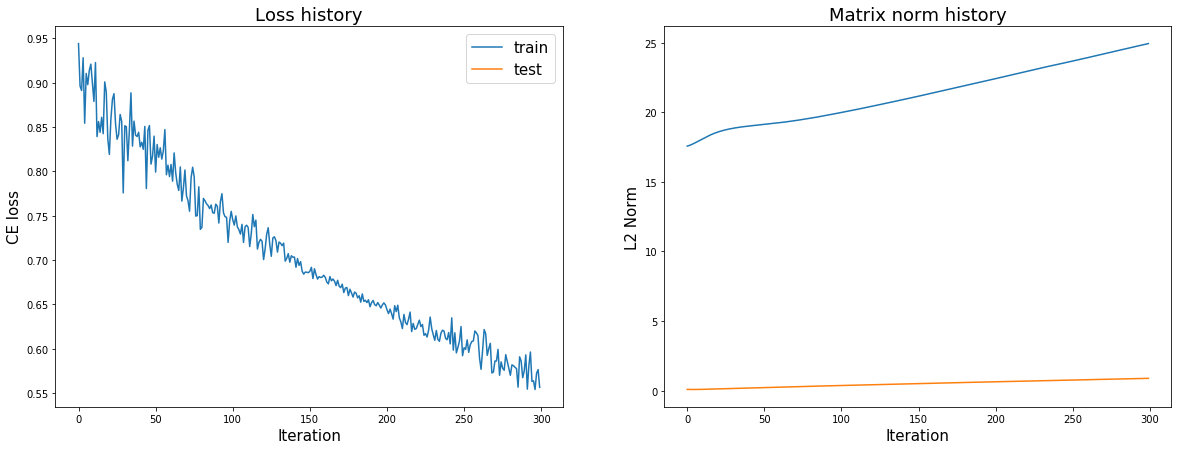

KeyboardInterrupt: 

In [236]:
for epoch in range(n_epochs):
    print('Epoch {}. Started training.'.format(epoch + 1))

    for it, batch in tqdm(enumerate(data_loader), total=len(dataset) // batch_size):
        model.train()
        hyponyms, candidates, labels = batch
        hyponyms = vocab.process_batch(hyponyms)
        candidates = vocab.process_batch(candidates)
        
        model_batch = {
            'batch': torch.LongTensor(hyponyms),
            'candidate': torch.LongTensor(candidates)
        }

        labels = labels.float()
        logits = model(model_batch).squeeze()
        loss = loss_fn(logits, labels)
        
        if np.isnan(loss.detach().numpy()):
            print(logits)
            break
        
        if len(loss_history) % val_freq == 0:
            test_loss_history.append(eval_loss_on_test(model, vocab))
        loss_history.append(loss.detach().numpy())
        matrix_norm = np.linalg.norm(model.matrices.detach().numpy())
        matrix_norms.append(matrix_norm)
        weight_norm = np.linalg.norm(model.prob_layer.weight.detach().numpy())
        weight_norms.append(weight_norm)
        
        if len(loss_history) % plot_frequency == 0:
            print(loss)
            clear_output(wait=True)
            plt.figure(figsize=(20, 7))
            
            plt.subplot(1, 2, 1)
            plt.title('Loss history', fontsize=18)
            plt.xlabel('Iteration', fontsize=15)
            plt.ylabel('CE loss', fontsize=15)
            plt.plot(np.array(loss_history), label='train')
            plt.plot(np.arange(len(test_loss_history)) * val_freq, np.array(test_loss_history), label='test')
            plt.legend(fontsize=15)
            
            plt.subplot(1, 2, 2)
            plt.title('Matrix norm history', fontsize=18)
            plt.xlabel('Iteration', fontsize=15)
            plt.ylabel('L2 Norm', fontsize=15)
            plt.plot(np.array(matrix_norms))
            plt.plot(np.array(weight_norms))
            
            plt.show()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        optimizer.zero_grad()

In [351]:
torch.save(model.state_dict(), '../data/models/projection_model_single.bin')

In [335]:
clamped

tensor([0.999999523162842, 0.999998688697815, 0.999999761581421,
        0.999999046325684, 0.999999880790710, 0.999999523162842,
        0.999999284744263, 0.999999642372131, 0.999999403953552,
        0.999999761581421, 0.999999165534973, 0.999998927116394,
        1.000000000000000, 0.999999165534973, 0.999997735023499,
        0.999998688697815, 0.999999284744263, 0.999998927116394,
        0.999998569488525, 0.999999284744263, 0.999999284744263,
        0.999999642372131, 0.999999523162842, 0.999998688697815,
        0.999999165534973, 0.999998450279236, 0.999999523162842,
        0.999999761581421, 0.999999523162842, 0.999999403953552,
        0.999999642372131, 0.999999284744263, 0.999998569488525,
        0.999999523162842, 0.999999761581421, 0.999999046325684,
        0.999999284744263, 0.999999761581421, 0.999999523162842,
        0.999999523162842, 0.999999523162842, 0.999999761581421,
        0.999999642372131, 0.999999761581421, 0.999997854232788,
        0.999999642372131

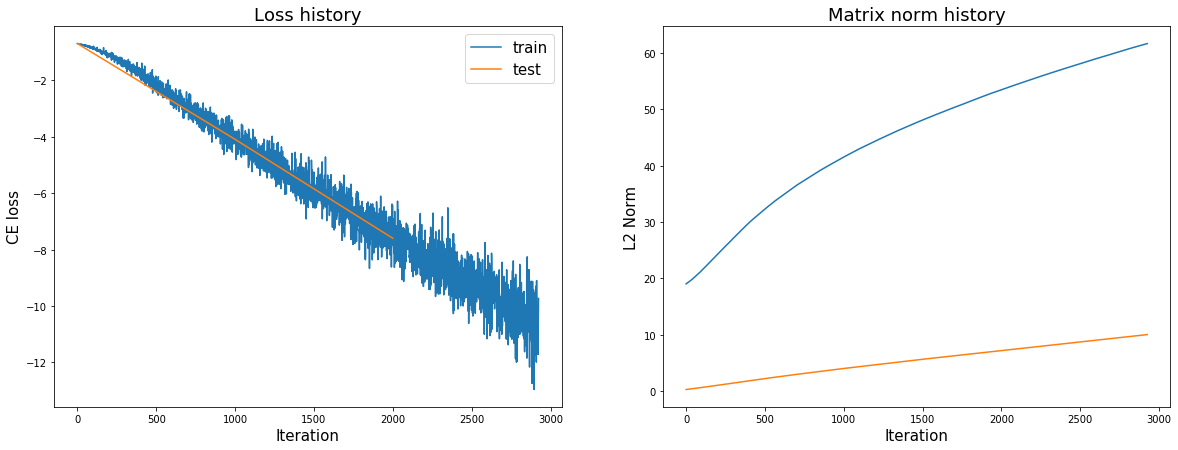

In [305]:
plt.figure(figsize=(20, 7))
            
plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('CE loss', fontsize=15)
plt.plot(np.array(loss_history), label='train')
plt.plot(np.arange(len(test_loss_history)) * val_freq, np.array(test_loss_history), label='test')
plt.legend(fontsize=15)
           
plt.subplot(1, 2, 2)
plt.title('Matrix norm history', fontsize=18)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('L2 Norm', fontsize=15)
plt.plot(np.array(matrix_norms))
plt.plot(np.array(weight_norms))

In [306]:
weight_norms[-10:]

[10.003188,
 10.006206,
 10.009219,
 10.012233,
 10.015238,
 10.01826,
 10.021319,
 10.0243845,
 10.027425,
 10.030435]

In [309]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], requires_grad=True)
Parameter containing:
tensor([[nan]], requires_grad=True)
Parameter containing:
tensor([nan], requires_grad=True)


In [310]:
loss_history[-10:]

[array(-11.564904, dtype=float32),
 array(-10.748442, dtype=float32),
 array(-10.634823, dtype=float32),
 array(-10.231451, dtype=float32),
 array(-11.301371, dtype=float32),
 array(-11.715054, dtype=float32),
 array(-10.933878, dtype=float32),
 array(-10.134322, dtype=float32),
 array(-9.730699, dtype=float32),
 array(-inf, dtype=float32)]